<a href="https://colab.research.google.com/github/Azuremis/make_your_first_gan_with_pytorch/blob/master/simple_pattern_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# import required libraries

import torch
import torch.nn as nn

import random
import numpy
import pandas
import matplotlib.pyplot as plt

Making real data source

In [9]:
# set up real data source
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)]
    )

    return real_data

In [10]:
# check range of numbers generated makes sense
generate_real()

tensor([0.9650, 0.1615, 0.9950, 0.1414])

Creating the discriminator

In [11]:
# set up the discriminator
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # set up nn layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

        # set up loss
        self.loss_function = nn.BCELoss()

        # set up optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # set up progress monitors
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # just run the model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate predictions
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # track training progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())  # accumulate error
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass by calcuating gradients
        loss.backward()
        # update learnable parameters
        self.optimiser.step()

    def plot_progress(self):

        df = pandas.DataFrame(self.progress, columns=["loss"])    
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


Testing the discriminator

In [12]:
# generates random noise
def generate_random(size):
    return torch.rand(size)

In [13]:
generate_random(4)

tensor([0.8801, 0.0968, 0.2381, 0.6003])

In [14]:
discrim = Discriminator()

for i in range(10000):
    # train with real data
    discrim.train(generate_real(), torch.FloatTensor([1.0]))
    # train with fake data
    discrim.train(generate_random(4), torch.FloatTensor([0.0]))


counter =  10000
counter =  20000


In [15]:
discrim.progress[:5]

[0.6994422674179077,
 0.7180208563804626,
 0.7131019830703735,
 0.7157678604125977,
 0.6945534348487854]

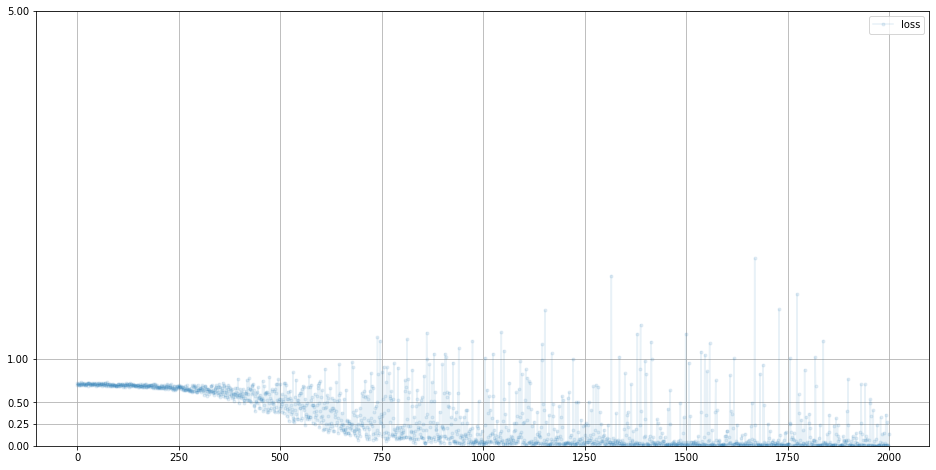

In [16]:
# plot model loss
discrim.plot_progress()

In [17]:
# manual run to check discriminitor is working
print("With real data:", discrim.forward(generate_real()).item())
print("With random data:", discrim.forward(generate_random(4)).item())

With real data: 0.9459968209266663
With random data: 0.011996911838650703


Creating the generator

In [18]:
class Generator(nn.Module):
    
    def __init__(self):
        # call parent pytorch class
        super().__init__()

        # set up nn layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # set up optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # set up progress trackers
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, discriminator, inputs, targets):
        # calculate network output i.e. generate data example
        generator_output = self.forward(inputs)

        # pass output to the discriminator to get classification
        discriminator_output = discriminator.forward(generator_output)

        # calculate error
        loss = discriminator.loss_function(discriminator_output, targets)

        # track progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass
        loss.backward()
        # update weights
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])    
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

Checking generator output

In [19]:
# check that generated data is right type and shape
seed = 0.6
gener = Generator()
gener.forward(torch.FloatTensor([seed]))

tensor([0.6399, 0.5556, 0.5536, 0.2732], grad_fn=<SigmoidBackward>)

Training the GAN

In [20]:
%%time

# create discriminator and generator
Dis = Discriminator()
Gen = Generator()

image_list = []  # image storage during training

# train discriminator and generator
for i in range(10000):

    # train the discriminator on true 
    Dis.train(generate_real(), torch.FloatTensor([1.0]))

    # train the discriminator on false, detach() means gradients not calculated for generator
    Dis.train(Gen.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    Gen.train(Dis, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    # track generated images after 1000 trianing runs
    if i % 1000 == 0:
        image_list.append(Gen.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000
counter =  20000
CPU times: user 16.4 s, sys: 2.34 ms, total: 16.4 s
Wall time: 16.4 s


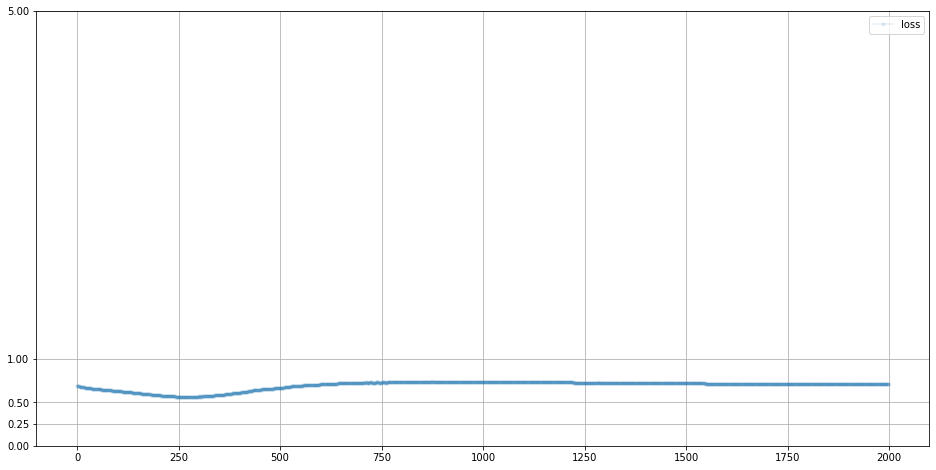

In [21]:
# plot discriminator loss
Dis.plot_progress()

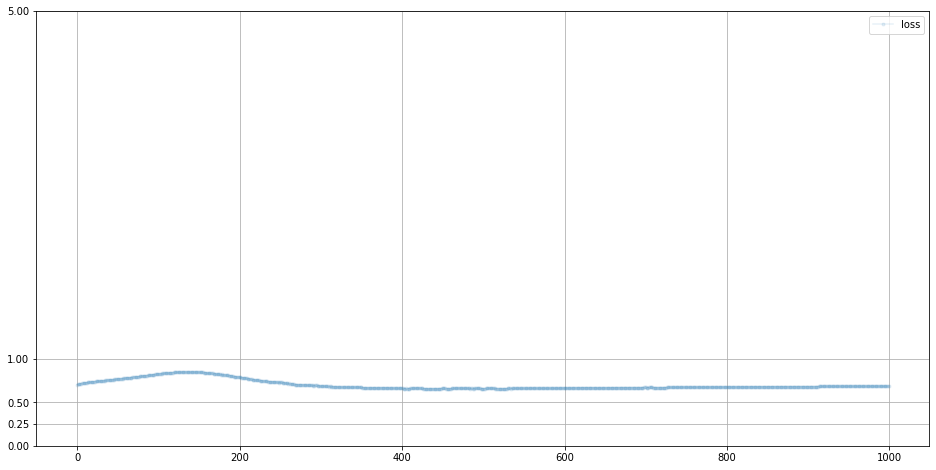

In [22]:
# plot generator loss
Gen.plot_progress()

In [23]:
# examine output of trained generator
Gen.forward(torch.FloatTensor([0.5]))

tensor([0.9789, 0.0250, 0.9703, 0.0258], grad_fn=<SigmoidBackward>)

Visualise GAN training pattern

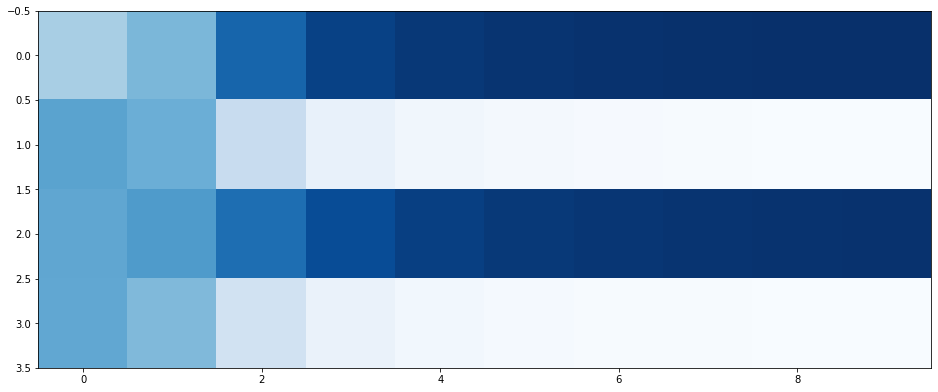

In [24]:
plt.figure(figsize=(16, 8))
plt.imshow(numpy.array(image_list).T, interpolation="none", cmap="Blues")